In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix

2025-12-25 11:49:07.586523: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 11:49:07.722921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 40
LR = 1e-5

TRAIN_DIR = "dataset/train"
TEST_DIR  = "dataset/test"

In [3]:

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="categorical"
)

val_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical"
)

NUM_CLASSES = train_data.num_classes
CLASS_NAMES = list(train_data.class_indices.keys())

print("Classes:", CLASS_NAMES)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

model_effnet.compile(
    optimizer=Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_effnet.summary()

16705208/16705208 [==============================] - 11s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)  

In [11]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4
    )
]

history_effnet = model_effnet.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/40


2025-12-25 14:55:42.688299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1436/1436 [==============================] - ETA: 0s - loss: 1.8695 - accuracy: 0.2388

2025-12-25 14:59:42.572107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1436/1436 [==============================] - 296s 200ms/step - loss: 1.8695 - accuracy: 0.2388 - val_loss: 1.7125 - val_accuracy: 0.3092 - lr: 1.0000e-05
Epoch 2/40
1436/1436 [==============================] - 272s 189ms/step - loss: 1.7447 - accuracy: 0.3044 - val_loss: 1.6514 - val_accuracy: 0.3517 - lr: 1.0000e-05
Epoch 3/40
1436/1436 [==============================] - 271s 189ms/step - loss: 1.6830 - accuracy: 0.3356 - val_loss: 1.6076 - val_accuracy: 0.3714 - lr: 1.0000e-05
Epoch 4/40
1436/1436 [==============================] - 281s 196ms/step - loss: 1.6449 - accuracy: 0.3578 - val_loss: 1.5781 - val_accuracy: 0.3884 - lr: 1.0000e-05
Epoch 5/40
1436/1436 [==============================] - 276s 192ms/step - loss: 1.6226 - accuracy: 0.3686 - val_loss: 1.5580 - val_accuracy: 0.3956 - lr: 1.0000e-05
Epoch 6/40
1436/1436 [==============================] - 264s 184ms/step - loss: 1.5918 - accuracy: 0.3787 - val_loss: 1.5349 - val_accuracy: 0.4060 - lr: 1.0000e-05
Epoch 7/40
1436/1436 

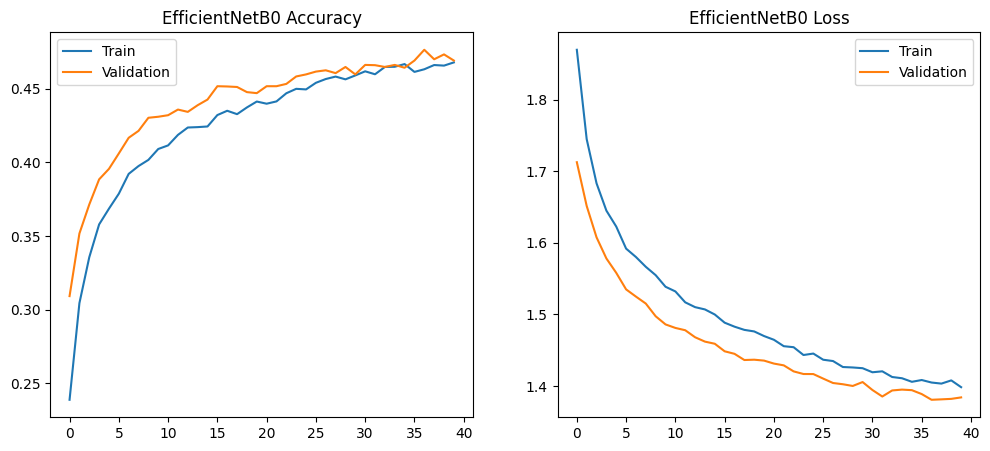

In [12]:
os.makedirs("results_effnet", exist_ok=True)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_effnet.history["accuracy"], label="Train")
plt.plot(history_effnet.history["val_accuracy"], label="Validation")
plt.title("EfficientNetB0 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_effnet.history["loss"], label="Train")
plt.plot(history_effnet.history["val_loss"], label="Validation")
plt.title("EfficientNetB0 Loss")
plt.legend()

plt.savefig("results_effnet/effnet_loss_accuracy.png", dpi=300)
plt.show()

In [13]:
y_true = test_data.classes
y_pred = np.argmax(model_effnet.predict(test_data), axis=1)

report = classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES,
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv("results_effnet/effnet_classification_report.csv")

df_report

2025-12-25 17:50:59.101690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


449/449 [==============================] - 54s 113ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
angry,0.377246,0.131524,0.195046,958.000000
disgust,0.000000,0.000000,0.000000,111.000000
fear,0.344743,0.137695,0.196790,1024.000000
happy,0.488905,0.770011,0.598074,1774.000000
neutral,0.457323,0.351987,0.397800,1233.000000
sad,0.342091,0.490778,0.403162,1247.000000
surprise,0.583610,0.634176,0.607843,831.000000
accuracy,0.446643,0.446643,0.446643,0.446643
macro avg,0.370560,0.359453,0.342674,7178.000000
weighted avg,0.425910,0.446643,0.410657,7178.000000


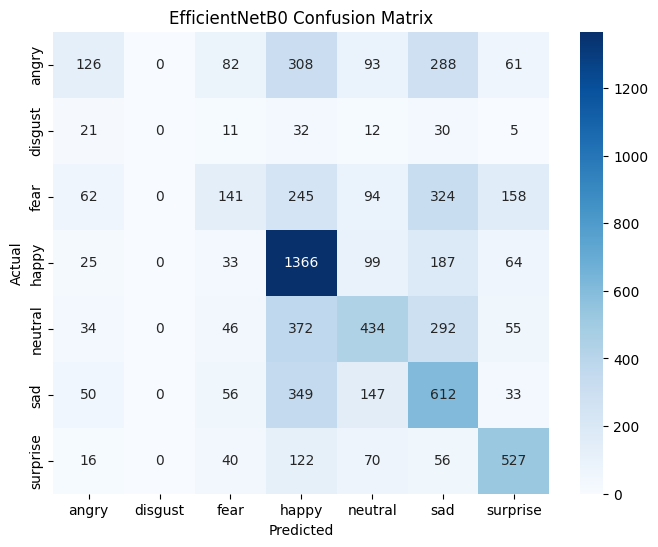

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("results_effnet/effnet_confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
model_effnet.save_weights(
    "results_effnet/efficientnet_model.h5"
)